In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import cvxpy as cp
from celluloid import Camera
import config
import core
import os
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation


# plt.ion()
# plt.close()

net = core.CLF_QP_Net(4, 256, 2)
net.load_state_dict(torch.load('./logs/model.pth'))
net.eval()

nominal_controller = core.LQR()
# camera = Camera(fig)
ss = []
for i in range(20):
    rho_init = np.random.uniform(10, 12)
    theta_init = np.random.uniform(np.pi/4, np.pi/3)
    v_init = np.random.uniform(-1, 1, size=2)
    s = np.array([[np.cos(theta_init) * rho_init, 
                  np.sin(theta_init) * rho_init,
                  v_init[0], v_init[1]]], dtype=np.float32)

    s = torch.from_numpy(s)

    for j in range(config.NUM_STEPS_PER_EPOCH):

        u_nominal = nominal_controller(np.squeeze(s.detach().numpy()))
        
        use_nominal = False
        s_np = np.squeeze(s.numpy())
        if s_np[1] < 0 and abs(s_np[0]) < abs(s_np[1]):
            u = torch.from_numpy(np.expand_dims(u_nominal, 0).astype(np.float32))
            use_nominal = True

        else:
            V, grad_V = net.compute_lyapunov(s)
            grad_V_np = np.squeeze(grad_V.detach().numpy())
            V_np = np.squeeze(V.detach().numpy())

            s_np = s.numpy()
            u = cp.Variable(2)
            clf_cond = grad_V_np @ (core.A.dot(s_np[0]) + core.B @ u) + 0.005 * V_np
            constraint = [clf_cond <= 0]

            objective = cp.Minimize(cp.sum_squares(u-u_nominal))

            cp.Problem(objective, constraint).solve()
            u = u.value
            u = torch.from_numpy(np.expand_dims(u, 0).astype(np.float32))

        dsdt = core.dynamics_torch(s, u)

        if use_nominal:
            timestep = config.TIME_STEP * 0.7
        else:
            timestep = config.TIME_STEP * 1.0

        s = torch.clip(s + dsdt * timestep, -7, 7)
        ss.append(s)
#         plt.clf()


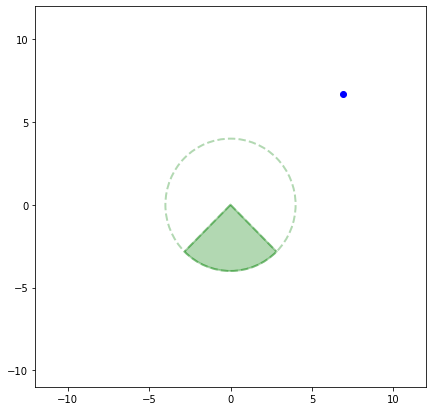

In [45]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

fig, ax = plt.subplots(figsize=(7, 7))

def animate(i):
    ax.clear()
    ax.set_xlim(-12, 12)
    ax.set_ylim(-11, 12)
    ax.add_patch(plt.Circle((0, 0), 4, color='g', alpha=0.3, fill=False, linewidth=2, linestyle='--'))
    ax.plot([0, -2.8], [0, -2.8], color='g', alpha=0.3, linewidth=2, linestyle='--')
    ax.plot([0, 2.8], [0, -2.8], color='g', alpha=0.3, linewidth=2, linestyle='--')

    ax.add_patch(patches.Wedge((0, 0), 4, -135, -45, linewidth=2,
                 edgecolor='g', facecolor='g', fill=True, alpha=0.3))
    line = ax.plot(ss[i][0, 0].item(),ss[i][0, 1].item(),marker='o', color='blue')
    return line

        
ani = FuncAnimation(fig, animate, interval=40, blit=True, repeat=True, frames=len(ss))    
ani.save("TLI11.gif", dpi=300, writer=PillowWriter(fps=25))

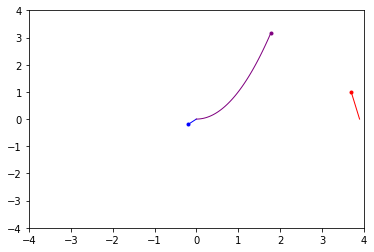

In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

x1 = np.arange(0, -0.2, -0.002)
y1 = np.arange(0, -0.2, -0.002)
x2 = np.arange(3.9, 3.7, -0.002)
y2 = np.arange(0, 1, 0.01)
x3 = np.arange(0, 1.8, 0.018)
y3 = np.array(x3**2)

fig,ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    line, = ax.plot(x1[0:i], y1[0:i], color = 'blue', lw=1)
    line2, = ax.plot(x2[0:i], y2[0:i], color = 'red', lw=1)
    line3, = ax.plot(x3[0:i], y3[0:i], color = 'purple', lw=1)
    point1, = ax.plot(x1[i], y1[i], marker='.', color='blue')
    point2, = ax.plot(x2[i], y2[i], marker='.', color='red')
    point3, = ax.plot(x3[i], y3[i], marker='.', color='purple')
#     print(i)
    return line, line2, line3, point1, point2, point3,
        
ani = FuncAnimation(fig, animate, interval=40, blit=True, repeat=True, frames=100)    
ani.save("TLI.gif", dpi=300, writer=PillowWriter(fps=25))

In [22]:
def animate(i):
    ax.clear()
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    line, = ax.scatter(x1[0:i], y1[0:i], color = 'blue', lw=1)
    line2, = ax.plot(x2[0:i], y2[0:i], color = 'red', lw=1)
    line3, = ax.plot(x3[0:i], y3[0:i], color = 'purple', lw=1)
    point1, = ax.plot(x1[i], y1[i], marker='.', color='blue')
    point2, = ax.plot(x2[i], y2[i], marker='.', color='red')
    point3, = ax.plot(x3[i], y3[i], marker='.', color='purple')
    print(i)
    return line, line2, line3, point1, point2, point3,

In [46]:
# https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

In [19]:
# https://matplotlib.org/stable/gallery/animation/dynamic_image.html

3


(<matplotlib.lines.Line2D at 0x2064c08a6d0>,
 <matplotlib.lines.Line2D at 0x2064bec8880>)

In [32]:
ss[0][0, 0].item()

7.0

In [33]:
ss[0][0, 1].item()

7.0

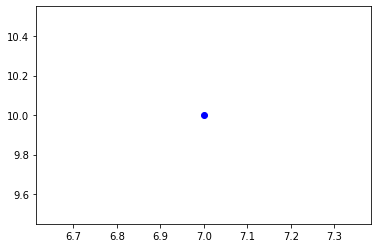

In [44]:
plt.plot(ss[0][0, 0].item(),ss[0][0, 1].item(),marker='o', color='blue')
plt.show()

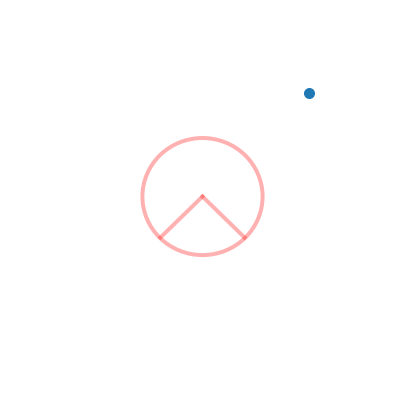

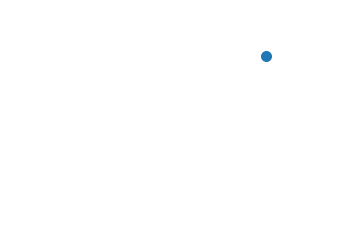

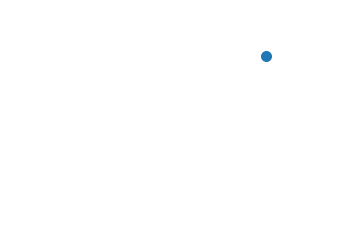

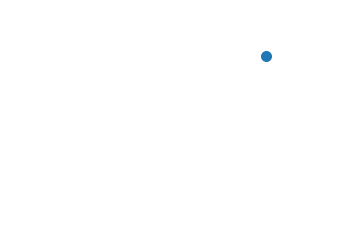

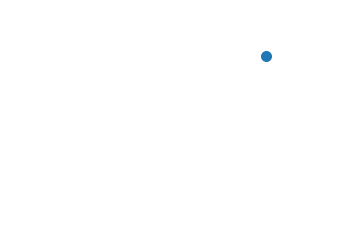

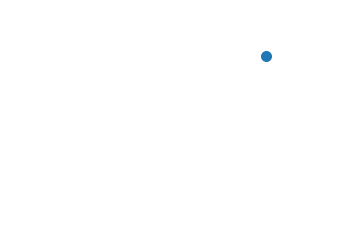

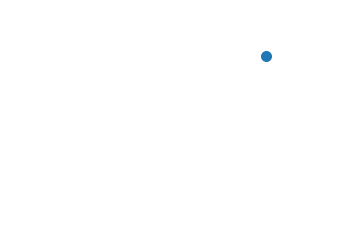

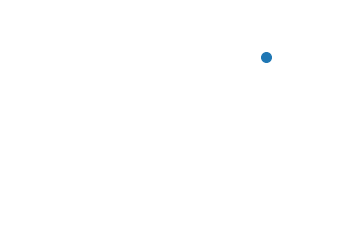

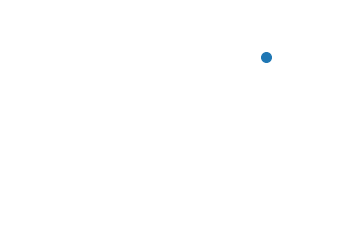

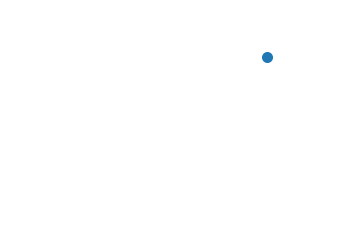

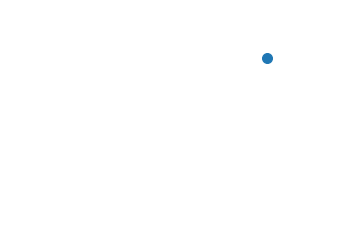

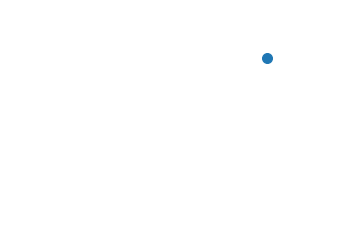

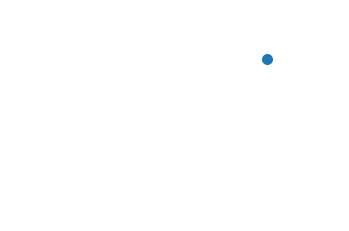

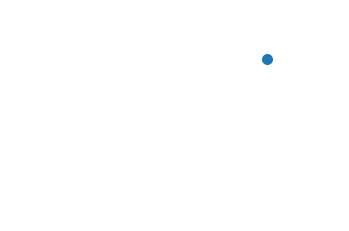

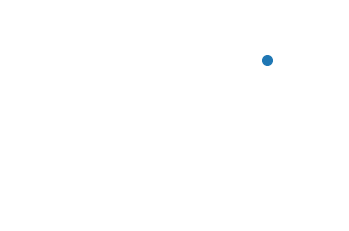

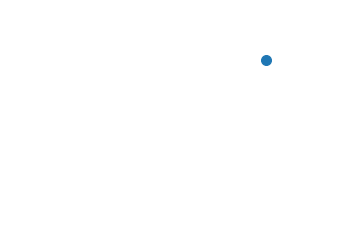

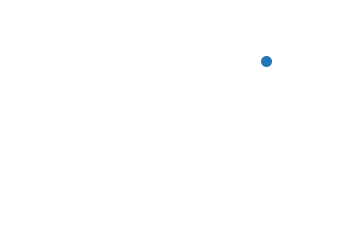

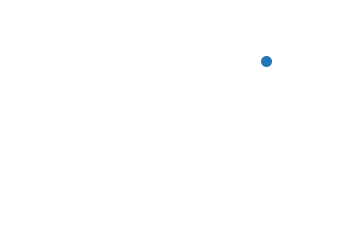

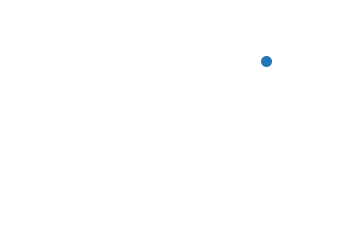

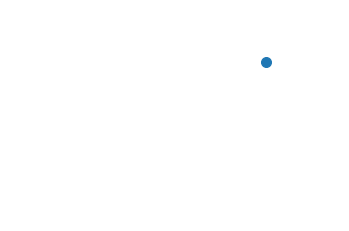

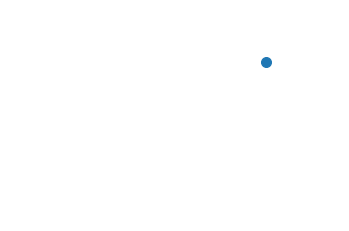

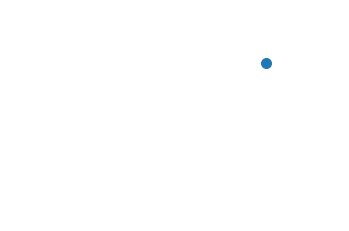

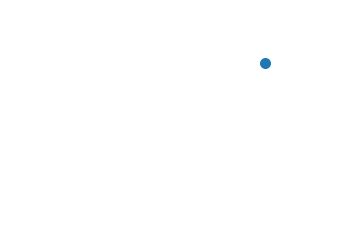

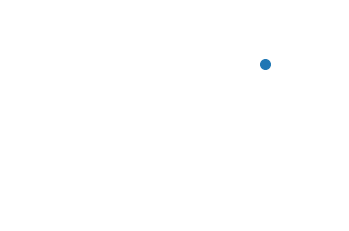

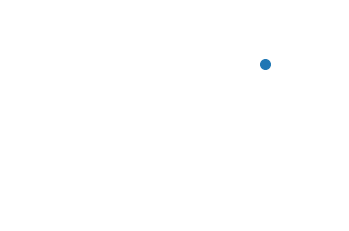

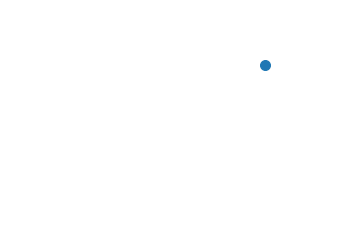

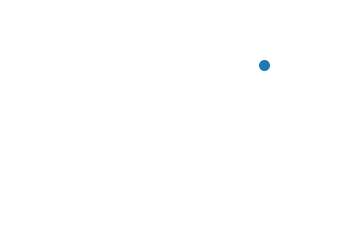

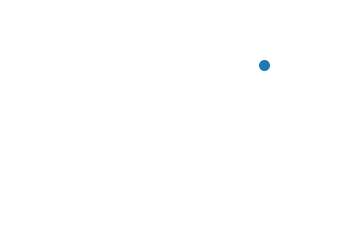

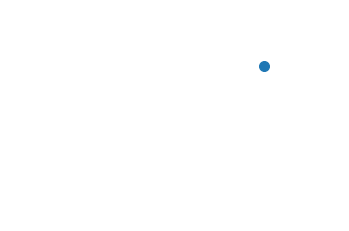

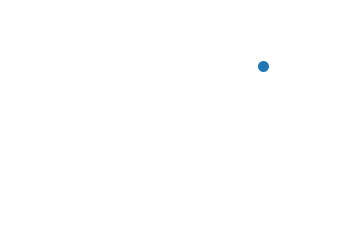

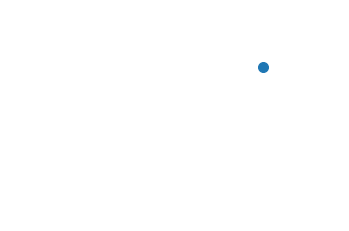

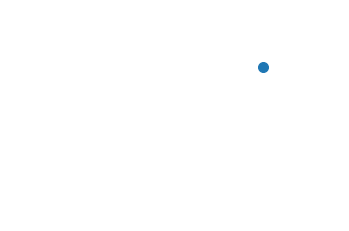

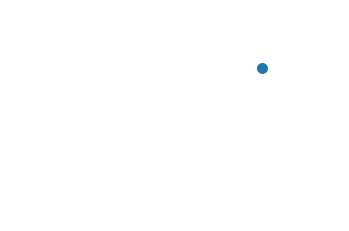

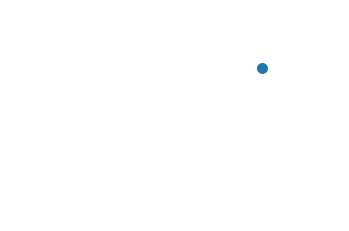

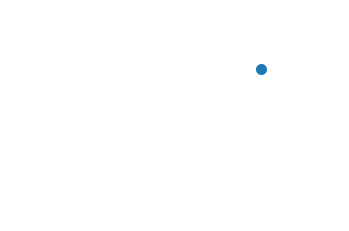

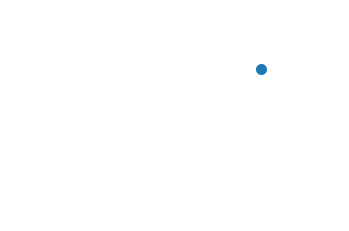

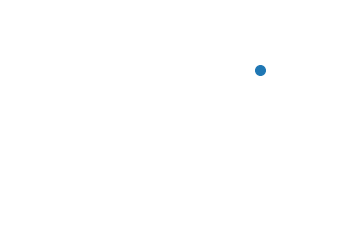

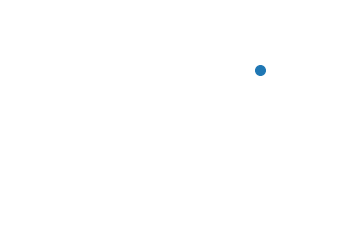

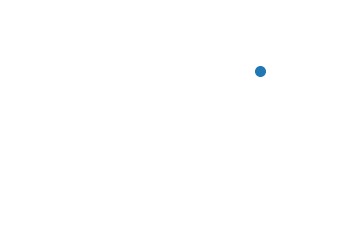

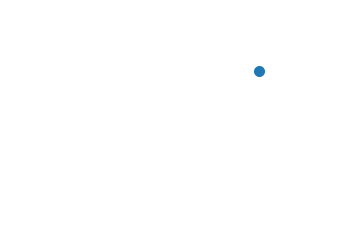

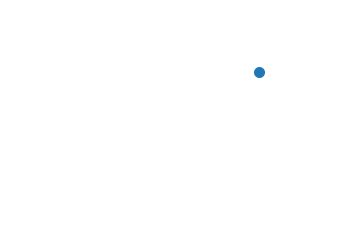

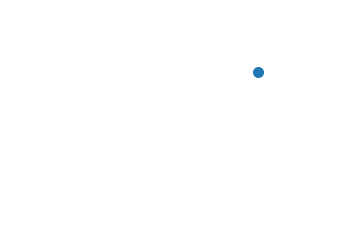

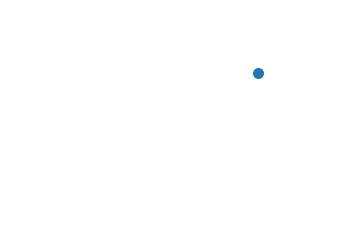

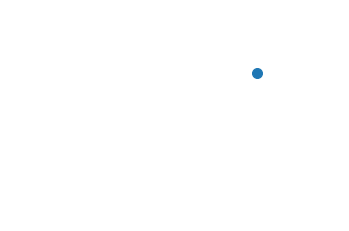

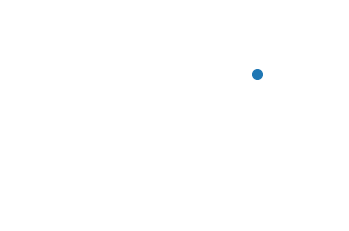

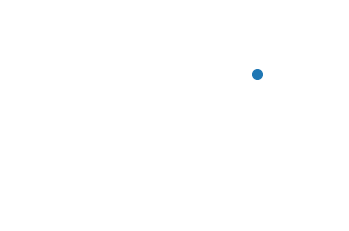

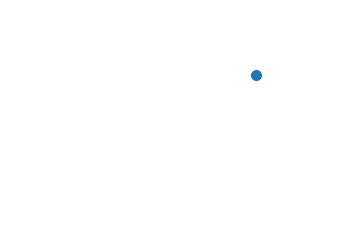

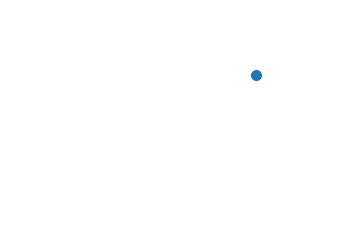

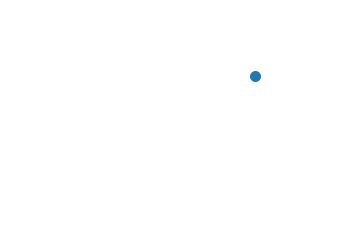

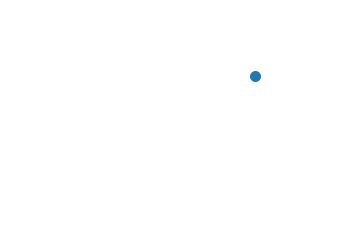

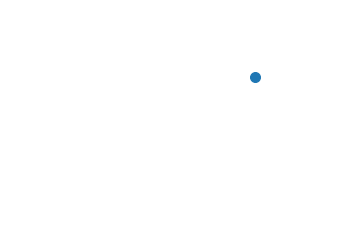

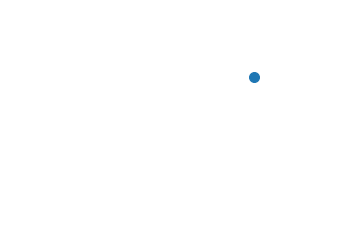

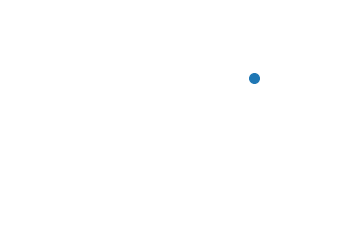

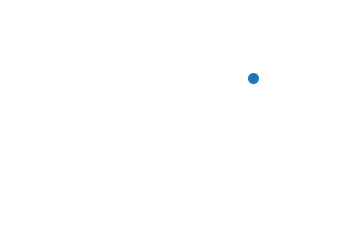

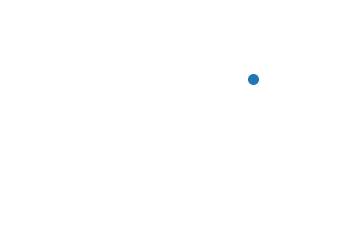

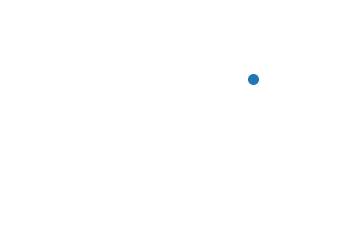

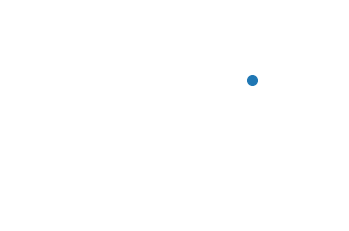

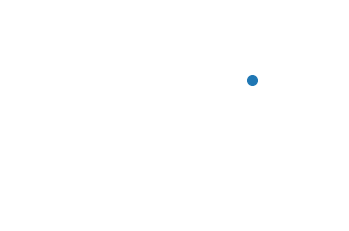

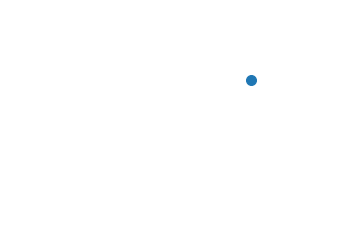

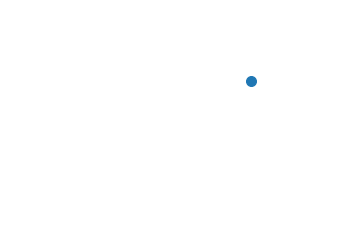

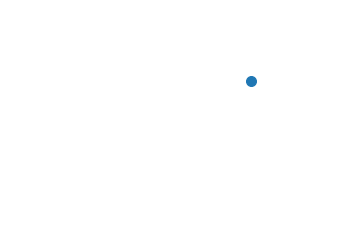

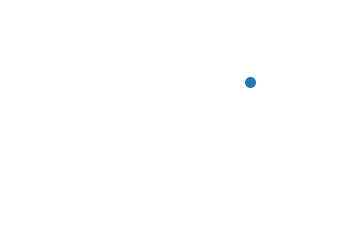

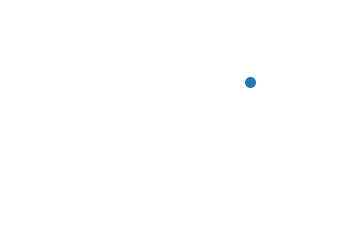

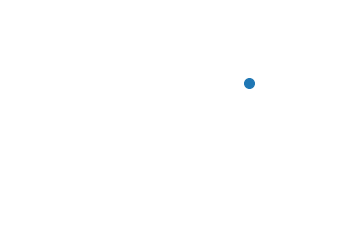

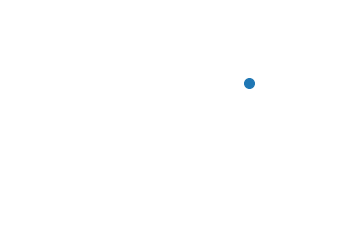

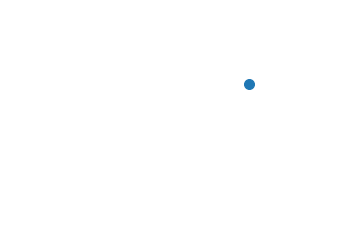

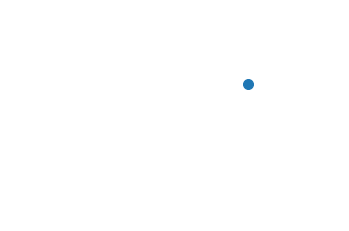

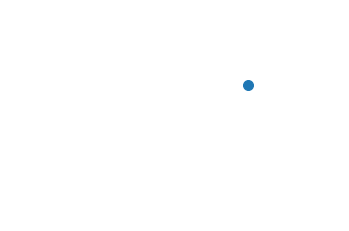

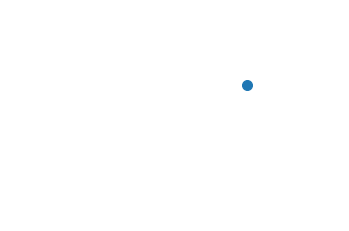

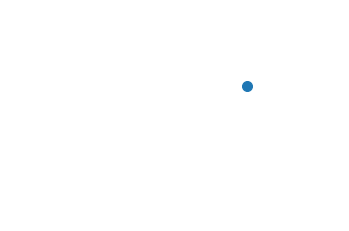

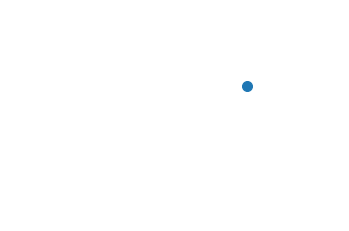

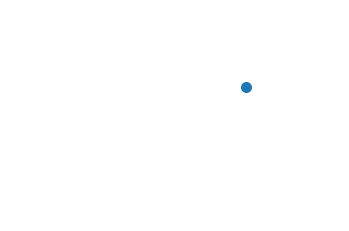

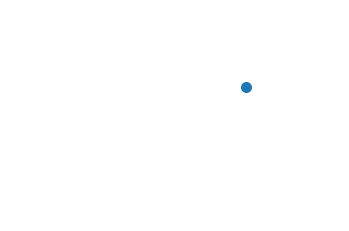

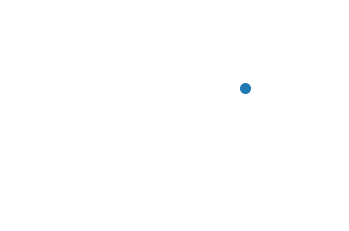

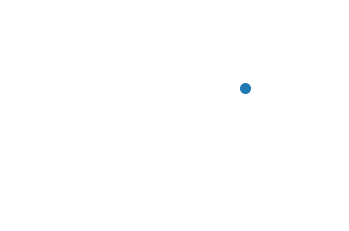

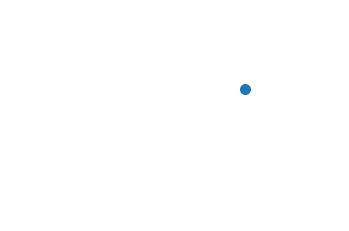

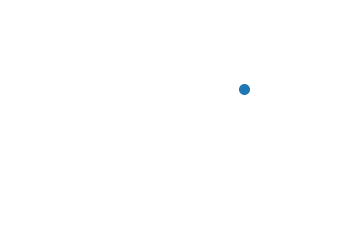

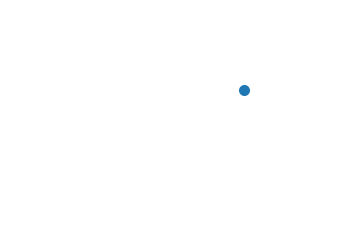

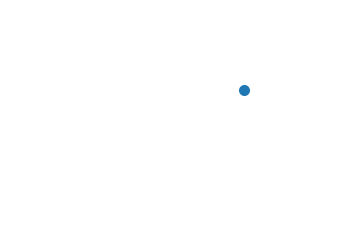

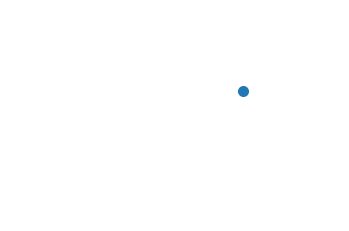

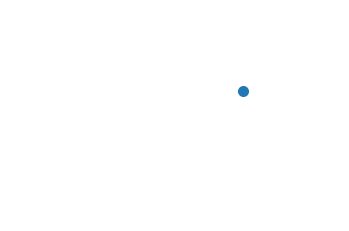

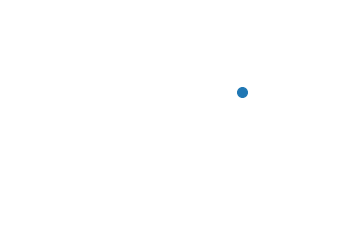

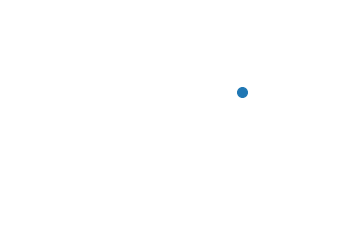

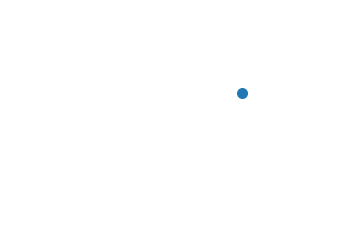

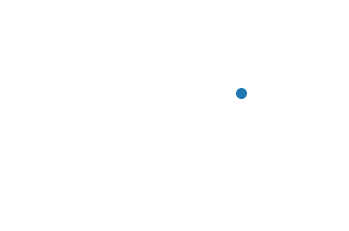

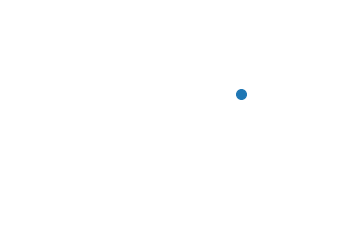

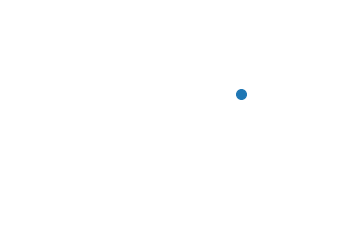

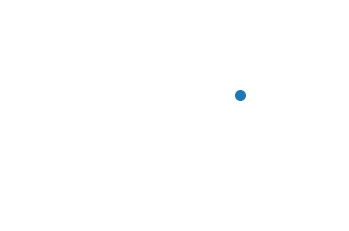

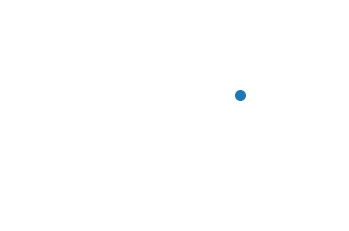

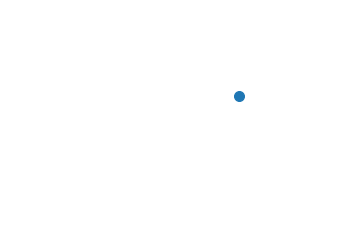

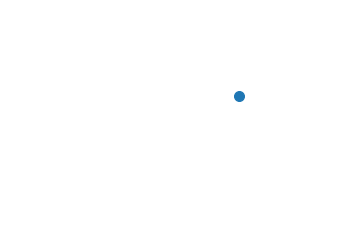

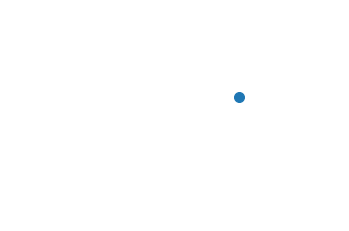

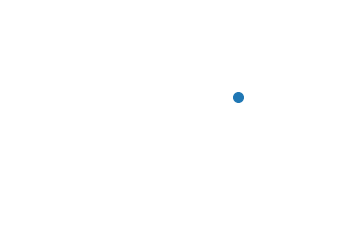

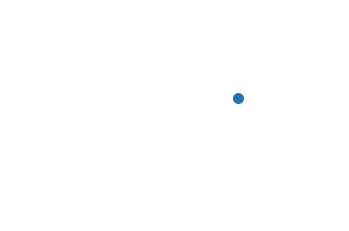

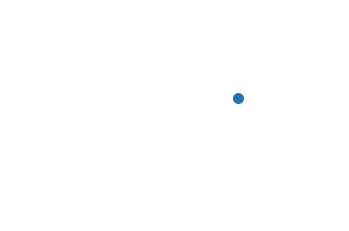

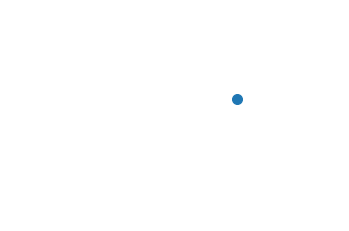

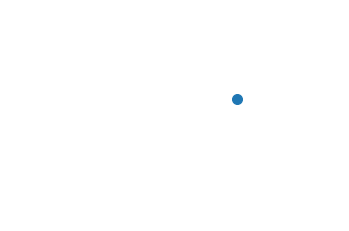

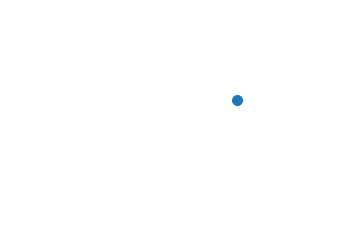

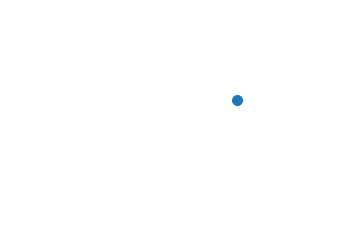

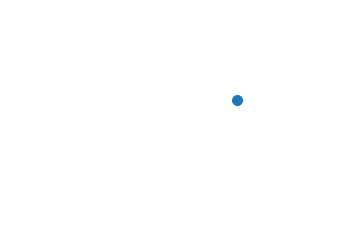

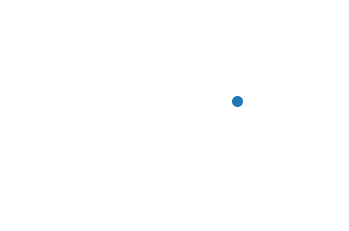

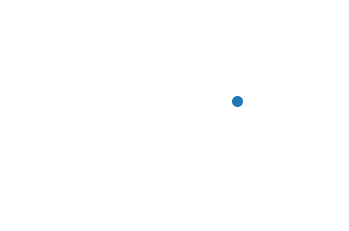

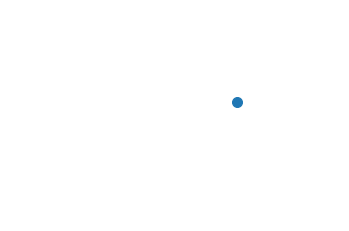

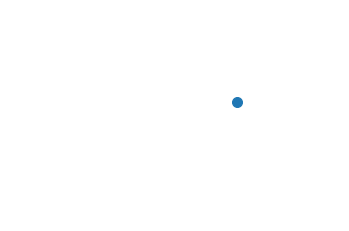

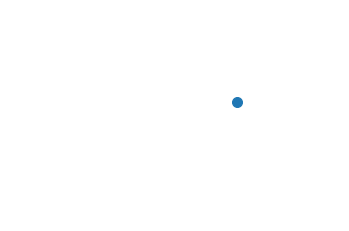

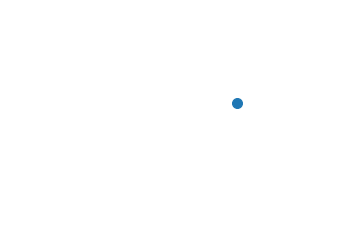

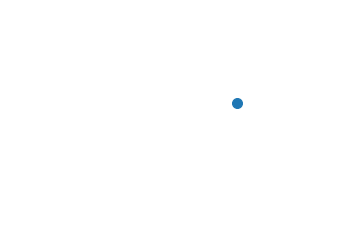

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [2]:
%run test_mpc_noise.py